In [22]:
# 다중 분류, 숫자 이미지의 짝수/홀수 판별, MLP, CPU

In [23]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os 
import random
import sys
import time
from time import localtime, strftime

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sb
import cv2

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ----------------------------------------------------------------
# OS
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
# ----------------------------------------------------------------

In [24]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
width=28
height=28

print('x_train.shape:', x_train.shape)

# 훈련 데이터 3차원 -> 2차원으로 변형, 60000행  X 784열
x_train = x_train.reshape(x_train.shape[0], width * height).astype('float32') / 255 
print('x_train.shape:', x_train.shape)

# 10000행 X 784열
x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 

x_train.shape: (60000, 28, 28)
x_train.shape: (60000, 784)


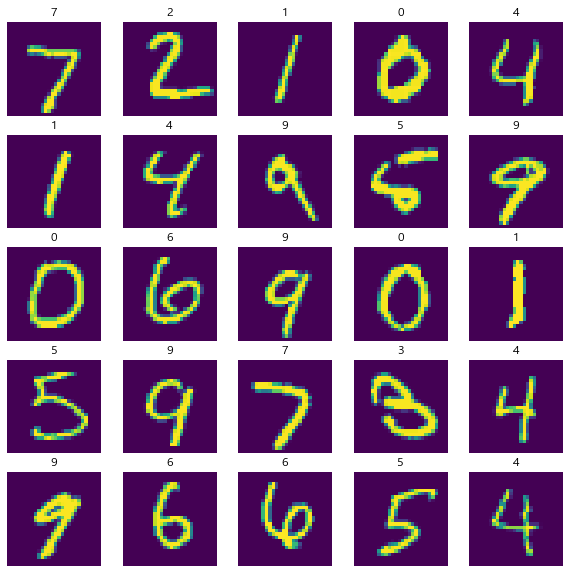

In [25]:
# 데이터 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row * plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i // plt_row, i % plt_col] # 행열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 2차원 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = y_test[i] # 0 ~ 9 숫자
        
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

In [26]:
# 반복 실행시 에러 발생, 변경 부분 확인
print(y_test[0:3])
y_train = to_categorical(y_train, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)
print(y_test.shape)
print(y_test[0:3])

[7 2 1]
(10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [27]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

width=28
height=28

(x_train_all, y_train_all), (x_test, y_test)  = mnist.load_data()

# 60000행  X 784열
x_train_all = x_train_all.reshape(x_train_all.shape[0], width * height).astype('float32') / 255 
x_test = x_test.reshape(x_test.shape[0], width * height).astype('float32') / 255 # 10000 X 784

y_train_all = to_categorical(y_train_all, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)

# 80%: 훈련, 20%: 검증
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.2,
                                                  random_state=SEED)

model = Sequential()
model.add(Dense(500, input_dim=784, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])

model.summary()

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)
start = time.time()
# 장비 속도가 느려 3번만 진행, 비교 목적
# 학습시 7을 1이라고 학습 시킴, 2는 0이라고 학습 시킴
hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                 epochs=3, batch_size=30, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# MLP기반에 CPU, GPU 사용시 왜 GUP가 느린 이유
# - 데이터가 아주 작을 경우, CPU가 GPU를 제어하는 시간 필요
# - Dense는 CPU에 최적화 되어 학습되는 구조
# - Dense에서도 가중치와 편향이 50만개이상으로 많아지면 GPU가 빨라짐.
# i5 2320 cpu: 48s
# RTX 3090: 15s, Colab gpu: 24s

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 500)               392500    
_________________________________________________________________
dense_11 (Dense)             (None, 400)               200400    
_________________________________________________________________
dense_12 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 694,210
Trainable params: 694,210
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1600/1600 [==============================] - 8s 5ms/step - loss: 0.3825 - accuracy: 0.8816 - val_loss: 0

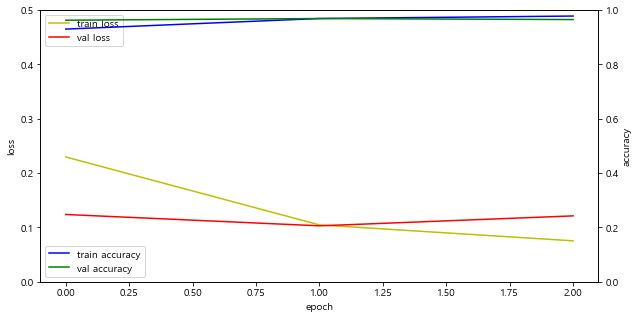

In [28]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=50, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.13827335834503174 /정확도: 96.06000185012817 %


In [30]:
model.save('./Mnist3_mlp.h5')

model = load_model('./Mnist3_mlp.h5')

yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

[[2.76929466e-08 2.26132374e-06 2.49468985e-06 7.14000805e-07
  2.50503092e-07 3.27971748e-08 8.34984304e-10 9.99944806e-01
  3.19732266e-07 4.89353479e-05]
 [2.69030380e-07 5.46446681e-05 9.99733269e-01 1.72037064e-04
  8.00645381e-08 3.04429051e-08 9.44361105e-08 3.81629761e-05
  1.31879972e-06 7.02863545e-09]
 [8.96620531e-06 9.98269081e-01 1.07326836e-04 4.18990858e-05
  1.27840147e-04 1.18585303e-05 1.91536892e-04 1.01290783e-03
  1.45547892e-04 8.28963748e-05]
 [9.99999642e-01 1.16554466e-11 1.40318406e-07 1.31986450e-10
  8.35036484e-10 5.07688291e-09 3.36955992e-08 3.51422691e-09
  1.63826925e-08 2.08150908e-07]
 [6.42080167e-08 1.21142207e-09 1.32642008e-09 2.14619624e-11
  9.99958396e-01 8.30457125e-08 1.71461579e-07 5.86134341e-09
  7.70958852e-09 4.12987029e-05]
 [1.49582991e-06 9.96324599e-01 1.58079511e-05 9.77500713e-06
  2.80458218e-04 3.01165051e-06 1.49980160e-05 3.04223690e-03
  5.73240977e-05 2.50380428e-04]
 [2.34703384e-06 8.08201492e-07 1.44501101e-07 1.21648597e

In [31]:
cnt = 0
for i in range(10): # 0 ~ 9
    title = str(np.argmax(y_test[i])) + ' / ' + str(np.argmax(yp[i]))
    print(title)

7 / 7
2 / 2
1 / 1
0 / 0
4 / 4
1 / 1
4 / 4
9 / 9
5 / 6
9 / 9


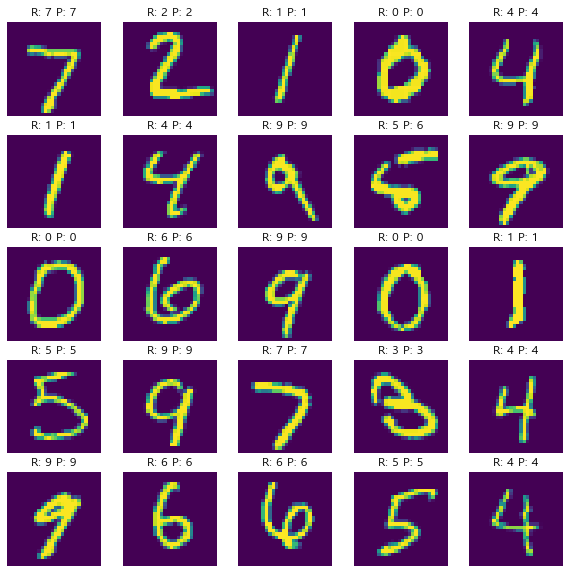

In [32]:
# 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()

## evaluation loss and_metrics ##
손실값: 0.13827340304851532  정확도: 96.06000185012817


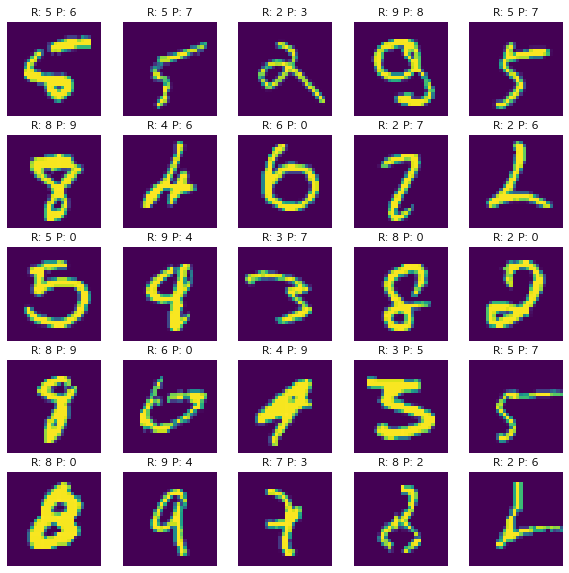

In [33]:
# 오답 이미지만 출력
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('## evaluation loss and_metrics ##')
print('손실값:',loss_and_metrics[0], ' 정확도:', (loss_and_metrics[1] * 100))

yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    
    if np.argmax(y_test[i]) == np.argmax(yhat_test[i]):
        i += 1
        continue # 정답일 경우 출력 안함.
    
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()